# **📖 07/01/21 Office Hours:** Using Dictionaries (with Time Series)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import matplotlib as mpl

In [2]:
# !pip install statsmodels==0.11

## Statmodels time series analysis 
import statsmodels.tsa.api as tsa

# !pip install -U pmdarima
import pmdarima as pmd
# help(pmd.auto_arima)

print("PACKAGE VERSIONS:")
import statsmodels 
print("statstmodels: ", statsmodels.__version__)
print("pandas: ",pd.__version__)
print("numpy: ",np.__version__)
print("matplotlib: ",mpl.__version__)
print("pmdarima: ",pmd.__version__)

PACKAGE VERSIONS:
statstmodels:  0.11.1
pandas:  1.0.5
numpy:  1.18.5
matplotlib:  3.3.2
pmdarima:  1.7.1


In [3]:

from random import gauss

pd.set_option('precision',3)
plt.rcParams['figure.figsize'] = [12,5]

## Plotly Express
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"




### Functions from Class

In [4]:
## appending folder with functions
import sys
sys.path.append("../../Phase_4/topic_38_time_series_models/")

## Functions from Last Class 
%load_ext autoreload
%autoreload 2
import ts_functions as tsf

In [5]:
## funtionize diagnosing
def diagnose_model(model):
    """Takes a fit statsmodels model and displays the .summary 
    and plots the built-in plot.diagnostics()"""
    display(model.summary())
    model.plot_diagnostics();
    plt.tight_layout()
    
    
def plot_acf_pacf(ts,figsize=(9,6),lags=52,suptitle=None,sup_y = 1.01):
    """Plot pacf and acf using statsmodels"""
    fig,axes=plt.subplots(nrows=2,figsize=figsize)
    
    tsa.graphics.plot_acf(ts,ax=axes[0],lags=lags);
    tsa.graphics.plot_pacf(ts,ax=axes[1],lags=lags);
    
    ## Add grid
    [ax.grid(axis='x',which='both') for ax in axes]
    
    if suptitle is not None:
        fig.suptitle(suptitle,y=sup_y,fontweight='bold',fontsize=15)
        
    fig.tight_layout()
    return fig,ax
    
    
### FORECAST SPECIFIC FUNCTIONS

def get_forecast(model,steps=12):
    pred = model.get_forecast(steps=steps)
    forecast = pred.conf_int()
    forecast.columns = ['Lower CI','Upper CI']
    forecast['Forecast'] = pred.predicted_mean
    return forecast

    


def evaluate_model(model,ts,last_n_lags =52,steps=12):
    display(model.summary())
    model.plot_diagnostics();
    fig,ax=plot_forecast(model,ts,future_steps=steps,last_n_lags=last_n_lags)
    return fig,ax


def model_evaluation(ts_true,ts_pred,show=True,show_u_info=False):
    from sklearn.metrics import mean_squared_error,r2_score

    res= [['Metric','Value']]
    
    res.append(['RMSE', np.sqrt(mean_squared_error(ts_true,ts_pred))])
    
    res.append(['R2',r2_score(ts_true,ts_pred)])
    res.append(["Thiel's U",thiels_U(ts_true,ts_pred,
                                            display_equation=show_u_info,
                                           display_table=show_u_info)])
    res = pd.DataFrame(res[1:],columns=res[0])#fs.list2df(res)
    res.set_index('Metric',inplace=True)
    res=res.T
    
    if show:
        display(res)
    return res
    

def thiels_U(ys_true=None, ys_pred=None,display_equation=True,display_table=True):
    """Calculate's Thiel's U metric for forecasting accuracy.
    Accepts true values and predicted values.
    Returns Thiel's U"""


    from IPython.display import Markdown, Latex, display
    import numpy as np
    display(Markdown(""))
    eqn=" $$U = \\sqrt{\\frac{ \\sum_{t=1 }^{n-1}\\left(\\frac{\\bar{Y}_{t+1} - Y_{t+1}}{Y_t}\\right)^2}{\\sum_{t=1 }^{n-1}\\left(\\frac{Y_{t+1} - Y_{t}}{Y_t}\\right)^2}}$$"

    # url="['Explanation'](https://docs.oracle.com/cd/E57185_01/CBREG/ch06s02s03s04.html)"
    markdown_explanation ="|Thiel's U Value | Interpretation |\n\
    | --- | --- |\n\
    | <1 | Forecasting is better than guessing| \n\
    | 1 | Forecasting is about as good as guessing| \n\
    |>1 | Forecasting is worse than guessing| \n"


    if display_equation and display_table:
        display(Latex(eqn),Markdown(markdown_explanation))#, Latex(eqn))
    elif display_equation:
        display(Latex(eqn))
    elif display_table:
        display(Markdown(markdown_explanation))

    if ys_true is None and ys_pred is None:
        return

    # sum_list = []
    num_list=[]
    denom_list=[]
    for t in range(len(ys_true)-1):
        num_exp = (ys_pred[t+1] - ys_true[t+1])/ys_true[t]
        num_list.append([num_exp**2])
        denom_exp = (ys_true[t+1] - ys_true[t])/ys_true[t]
        denom_list.append([denom_exp**2])
    U = np.sqrt( np.sum(num_list) / np.sum(denom_list))
    return U

In [6]:
def plot_forecast_vs_test(model,ts_train,ts_test,steps=None, get_metrics=True):
    if steps is None:
        steps = len(ts_test)
    preds_df =  get_forecast(model, steps=steps)
    

    fig, ax = plt.subplots()
    ts_train.plot(ax=ax,label='Training Data')
    ts_test.plot(ax=ax,label='Test Data')

    
    preds_df['Forecast'].plot(ax=ax,label='Forecast')
    ax.fill_between(preds_df.index, 
                    preds_df["Lower CI"],
                    preds_df["Upper CI"], 
                    color="g", alpha=.15,
                    label = 'confidence interval')    
    
    ax.legend()
    ax.set(title=f"Predictions for {ts_train.name}")
    plt.show()    
    
    
    if get_metrics:
        res = model_evaluation(ts_test, preds_df['Forecast'])
#         res['Metric']

    return res, fig,ax


def expected_roi(investment, final_value):
    """This function takes in a series of forecasts to predict the return
    on investment spanning the entire forecast."""
    roi = np.round(((final_value - investment) / investment)*100,3)
    return roi



### Loading in Time Series

In [7]:
## Load in file and parse_dates, check index
file ="Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv.gz"#"https://raw.githubusercontent.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/master/Phase_4/topic_37_intro_to_time_series/baltimore_crime_counts_2021.csv"
df = pd.read_csv(file)#,parse_dates=True, index_col='CrimeDateTime')
display(df.head(),df.index)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1.280e+06,1.287e+06,1.292e+06,1.296e+06,1.300e+06,1.297e+06,1.290e+06,1.286e+06,1.286e+06,1.288e+06
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,471009.0,...,9.951e+05,9.999e+05,1.005e+06,1.009e+06,1.012e+06,1.014e+06,1.018e+06,1.021e+06,1.027e+06,1.031e+06
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,588310.0,...,1.644e+06,1.645e+06,1.653e+06,1.662e+06,1.671e+06,1.674e+06,1.677e+06,1.682e+06,1.692e+06,1.706e+06
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,202494.0,...,3.440e+05,3.456e+05,3.481e+05,3.512e+05,3.556e+05,3.600e+05,3.651e+05,3.706e+05,3.770e+05,3.839e+05
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,644605.0,...,1.279e+06,1.285e+06,1.291e+06,1.296e+06,1.300e+06,1.302e+06,1.308e+06,1.311e+06,1.317e+06,1.320e+06


RangeIndex(start=0, stop=30809, step=1)

In [8]:
def melt_data(df_,new=True):
    
    if new:
        df = df_.drop(columns=['RegionType','StateName'])

    else:
        df = df_
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [9]:
## Melt dataframe, set dt index
df = melt_data(df)
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month').sort_index()
# df = df.loc['2010':]
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-01-31,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,471009.0
1996-01-31,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,2,588310.0
1996-01-31,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,3,202494.0
1996-01-31,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,644605.0
1996-01-31,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,98243.0


In [10]:
## Sep MD state
md = df.groupby('State').get_group('MD')
md

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-01-31,66843,21234,Parkville,MD,Baltimore-Columbia-Towson,Baltimore County,78,1.152e+05
1996-01-31,66705,20906,Silver Spring,MD,Washington-Arlington-Alexandria,Montgomery County,175,1.875e+05
1996-01-31,67010,21740,Hagerstown,MD,Hagerstown-Martinsburg,Washington County,220,9.927e+04
1996-01-31,66785,21117,Owings Mills,MD,Baltimore-Columbia-Towson,Baltimore County,247,1.682e+05
1996-01-31,66683,20878,Gaithersburg,MD,Washington-Arlington-Alexandria,Montgomery County,299,2.557e+05
...,...,...,...,...,...,...,...,...
2021-05-31,66968,21670,Sudlersville,MD,Baltimore-Columbia-Towson,Queen Annes County,34192,1.967e+05
2021-05-31,66892,21522,Grantsville,MD,NaN,Garrett County,34322,1.992e+05
2021-05-31,66728,21020,Reisterstown,MD,Baltimore-Columbia-Towson,Baltimore County,34322,3.545e+05


In [11]:
## Make sep dfs for Baltimore City vs County
df_city =  df.groupby('CountyName').get_group('Baltimore City')
df_county = df.groupby('CountyName').get_group('Baltimore County')

display(df_city.head(),df_county.head())

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-01-31,66825,21215,Baltimore,MD,Baltimore-Columbia-Towson,Baltimore City,368,88187.0
1996-01-31,66834,21224,Baltimore,MD,Baltimore-Columbia-Towson,Baltimore City,484,99247.0
1996-01-31,66828,21218,Baltimore,MD,Baltimore-Columbia-Towson,Baltimore City,744,77770.0
1996-01-31,66816,21206,Baltimore,MD,Baltimore-Columbia-Towson,Baltimore City,783,87781.0
1996-01-31,66839,21229,Baltimore,MD,Baltimore-Columbia-Towson,Baltimore City,1088,90909.0


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-01-31,66843,21234,Parkville,MD,Baltimore-Columbia-Towson,Baltimore County,78,115245.0
1996-01-31,66785,21117,Owings Mills,MD,Baltimore-Columbia-Towson,Baltimore County,247,168154.0
1996-01-31,66832,21222,Dundalk,MD,Baltimore-Columbia-Towson,Baltimore County,423,100593.0
1996-01-31,66838,21228,Catonsville,MD,Baltimore-Columbia-Towson,Baltimore County,861,142783.0
1996-01-31,66817,21207,Lochearn,MD,Baltimore-Columbia-Towson,Baltimore County,874,103016.0


In [12]:
print(f"[i] There are {df_city['RegionName'].nunique()} zipcodes in Baltimore City")
print(f"[i] There are {df_county['RegionName'].nunique()} zipcodes in Baltimore County")

[i] There are 20 zipcodes in Baltimore City
[i] There are 42 zipcodes in Baltimore County


In [13]:
## make a dictionary of baltimore city zips
BCTY = {}
for zipcode in df_city['RegionName'].unique():
    temp = df_city.groupby("RegionName").get_group(zipcode)['MeanValue']
    temp.name = zipcode
    BCTY[str(zipcode)]=temp.resample('M').asfreq()
BCTY

{'21215': Month
 1996-01-31     88187.0
 1996-02-29     87954.0
 1996-03-31     87740.0
 1996-04-30     87312.0
 1996-05-31     87119.0
                 ...   
 2021-01-31    160810.0
 2021-02-28    161258.0
 2021-03-31    162256.0
 2021-04-30    163150.0
 2021-05-31    164894.0
 Freq: M, Name: 21215, Length: 305, dtype: float64,
 '21224': Month
 1996-01-31     99247.0
 1996-02-29     99135.0
 1996-03-31     98991.0
 1996-04-30     98831.0
 1996-05-31     98807.0
                 ...   
 2021-01-31    195686.0
 2021-02-28    197302.0
 2021-03-31    199505.0
 2021-04-30    202326.0
 2021-05-31    205285.0
 Freq: M, Name: 21224, Length: 305, dtype: float64,
 '21218': Month
 1996-01-31     77770.0
 1996-02-29     78244.0
 1996-03-31     78506.0
 1996-04-30     78835.0
 1996-05-31     78901.0
                 ...   
 2021-01-31    176393.0
 2021-02-28    179169.0
 2021-03-31    182285.0
 2021-04-30    185686.0
 2021-05-31    188921.0
 Freq: M, Name: 21218, Length: 305, dtype: float64,
 '21

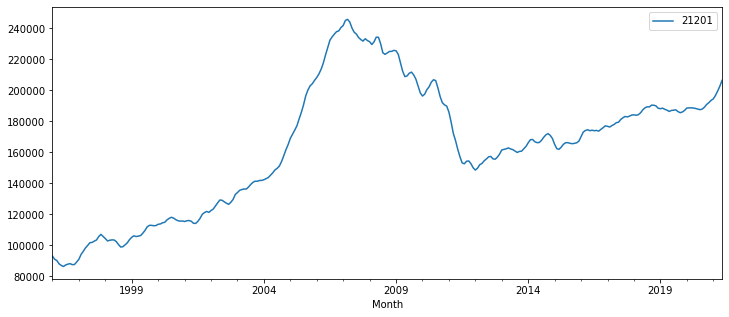

In [14]:
## pulling out individual zipcode
ts = BCTY['21201'].copy()
ax = ts.plot()
ax.legend()

In [15]:
ts.index

DatetimeIndex(['1996-01-31', '1996-02-29', '1996-03-31', '1996-04-30',
               '1996-05-31', '1996-06-30', '1996-07-31', '1996-08-31',
               '1996-09-30', '1996-10-31',
               ...
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31'],
              dtype='datetime64[ns]', name='Month', length=305, freq='M')

### Train-Test-Split for Time Series

In [16]:
# get the tts_cutoff  (the # of timesteps/rows to split at)
tts_cutoff = round(ts.shape[0]*0.80)
tts_cutoff_date = ts.index[tts_cutoff]
print("integer cutoff index: ",tts_cutoff)
print("corresponding cutoff date: ",tts_cutoff_date)

integer cutoff index:  244
corresponding cutoff date:  2016-05-31 00:00:00


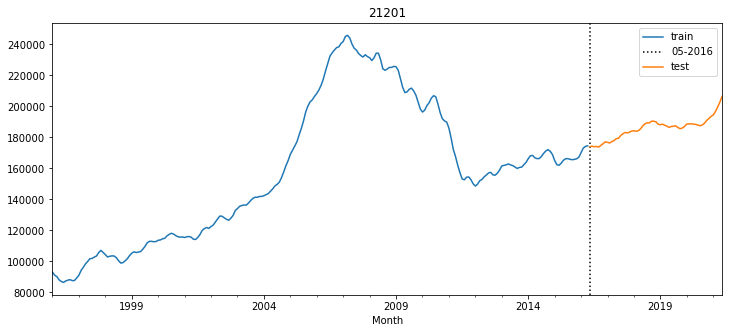

In [17]:
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

## Plot
ax = train.plot(label='train',title=train.name,)
ax.axvline(tts_cutoff_date, ls=":",c='k',
           label=tts_cutoff_date.strftime("%m-%Y"),
          )
test.plot(label='test')
ax.legend()

In [18]:
def train_test_split_ts(ts,split=0.80,plot=True,verbose=False):
    # get the tts_cutoff  (the # of timesteps/rows to split at)
    tts_cutoff = round(ts.shape[0]*split)
    tts_cutoff_date = ts.index[tts_cutoff]
    if verbose:
        print("integer cutoff index: ",tts_cutoff)
        print("corresponding cutoff date: ",tts_cutoff_date)
    train = ts.iloc[:tts_cutoff]
    test = ts.iloc[tts_cutoff:]
    
    if plot:
        ## Plot
        ax = train.plot(label='train',title=train.name,)
        ax.axvline(tts_cutoff_date, ls=":",c='k',
                   label=tts_cutoff_date.strftime("%m-%Y"),
                  )
        test.plot(label='test')
        ax.set_title(ts.name)
        ax.legend()
        
    return train, test

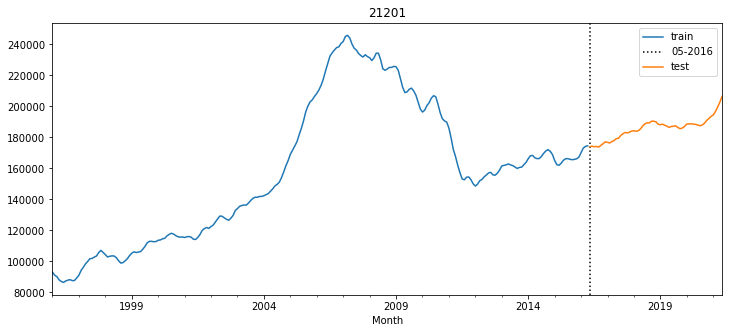

In [19]:
train,test = train_test_split_ts(ts)

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-1.549,14,229,0.509,False,False


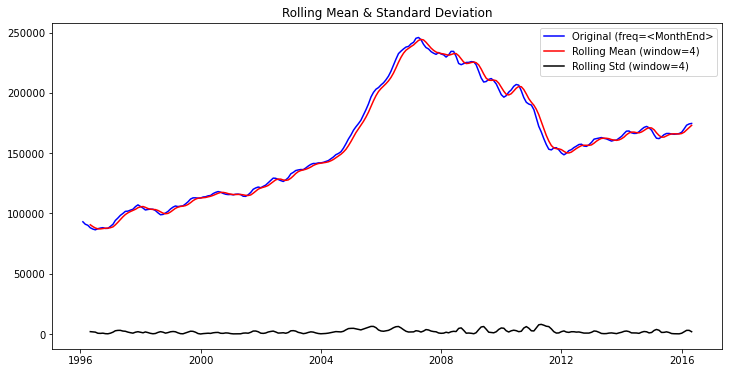

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-1.549,14,229,0.509,False,False


In [20]:
## check staationarity 
tsf.stationarity_check(train, window=4)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



(<Figure size 648x432 with 2 Axes>,
 <AxesSubplot:title={'center':'21201'}, xlabel='Month'>)

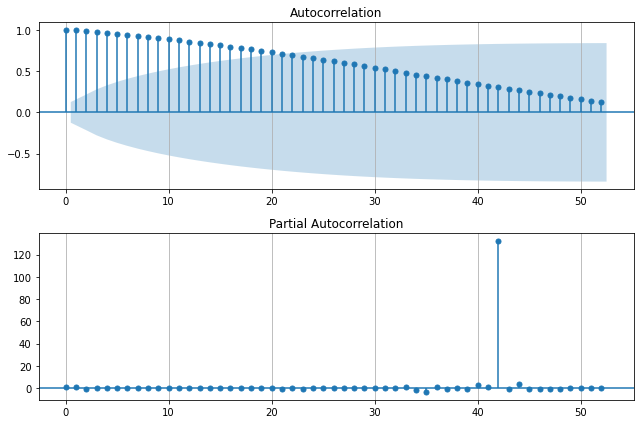

In [21]:
### Check PACF/ACF to infer p/q (if possible)
plot_acf_pacf(train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



(<Figure size 648x432 with 2 Axes>,
 <AxesSubplot:title={'center':'21201'}, xlabel='Month'>)

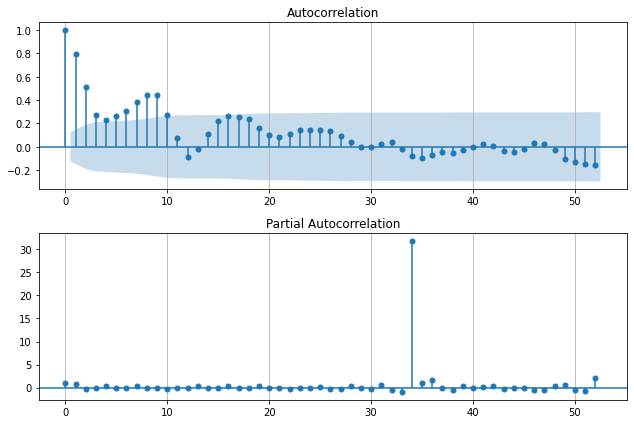

In [22]:
### Check PACF/ACF to infer p/q (if possible)
plot_acf_pacf(train.diff().dropna())

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



(<Figure size 648x432 with 2 Axes>,
 <AxesSubplot:title={'center':'21201'}, xlabel='Month'>)

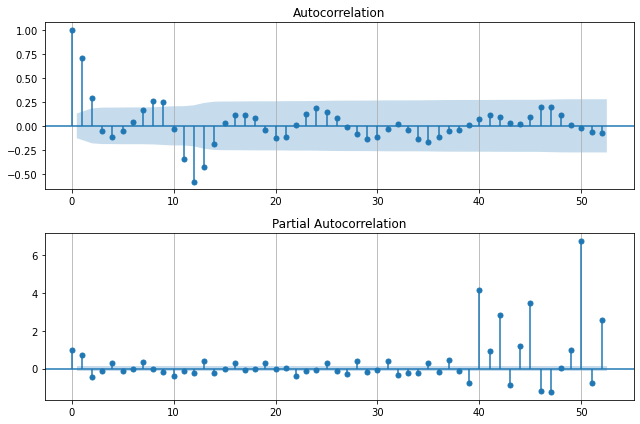

In [23]:
### Check PACF/ACF to infer p/q (if possible)
plot_acf_pacf(train.diff(1).diff(12).dropna())

- Possible values:
    - p:
    - d:
    - q:

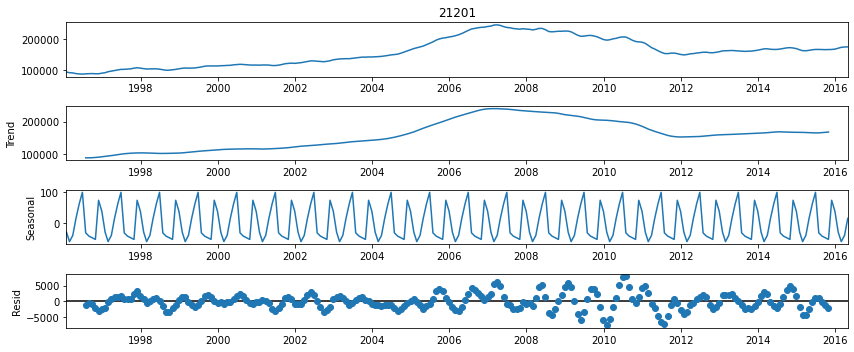

In [24]:
## Use Seasonal Decompose to check for seasonality 
decomp = tsa.seasonal_decompose(train)
decomp.plot();

>- **NOTE: I removed the use of any functions from the rest of the workflow** in order to make it more transparent as to what we are doing.
    - I HIGHLY recommend functionizing a lot of longer blocks of code that you will need to repeat for each model/zipcode/stock.

In [25]:
# ## Gridsearch params
# auto_model = pmd.auto_arima(train,start_p=0,max_p=5,
#                            start_q=0,max_q=5,d=1,m=12,
#                            start_P=0,start_Q=0,maxiter=300,
#                             verbose=True,trace=True)

# display(auto_model.summary())

In [26]:
# ## Fit a final model and evaluate
# best_model = tsa.SARIMAX(train,order=auto_model.order,
#                         seasonal_order = auto_model.seasonal_order,
#                         enforce_invertibility=False,
#                          enforce_stationarity=True).fit()


# ## Display Summary + Diagnostics
# display(best_model.summary())
# best_model.plot_diagnostics();
# plt.tight_layout()

In [27]:
    
# res,_,_= plot_forecast_vs_test(best_model,train,test)

In [28]:
# ## If happy with the model's test perforamance, retrain on entire ts and forecast into future
# ## Fit a final model and evaluate
# final_model = tsa.SARIMAX(ts,order=auto_model.order,
#                 seasonal_order = auto_model.seasonal_order,
#                 enforce_invertibility=False).fit()


# ## Display Summary + Diagnostics
# display(final_model.summary())
# final_model.plot_diagnostics();
# plt.tight_layout()

In [29]:
def plot_future_forecast(model,ts,last_n_lags=None,
                         future_steps=12, 
                        ):
    if last_n_lags is None:
        last_n_lags = len(ts)
        
    forecast_df = get_forecast(model,steps=future_steps)

    fig,ax = plt.subplots(figsize=(12,5))
    ts.iloc[-last_n_lags:].plot(label='True Data')
    
    ax.axvline(forecast_df.index[0],ls=":",c='k')
    forecast_df['Forecast'].plot(ax=ax)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], forecast_df['Upper CI'],alpha=0.6)
    ax.legend()
    ax.set(title=f'Forecasted {ts.name}')
    
#     if get_roi:
    roi = expected_roi_from_forecast_df(forecast_df)
    roi.reset_index(inplace=True)
    roi.rename({'index':'Sale Date'},axis=1,inplace=True)
    roi.index=[ts.name]
    roi = roi[['Investment Cost','Sale Date','Forecast','Lower CI','Upper CI']]
    display(roi)
    return fig,roi



    
def expected_roi_from_forecast_df(preds_df):
    preds_df.sort_index(ascending=True,inplace=True)
    
    investment = preds_df['Forecast'].iloc[0]
    roi_df = np.round((preds_df - investment )/investment*100,3)
    roi_df['Investment Cost'] = investment
    
    roi = roi_df.iloc[-1].to_frame().T
    return roi
    
    


In [30]:
# RESULTS = {}

In [31]:
# fig,roi = plot_future_forecast(final_model,ts,last_n_lags=12*10,future_steps=24);
# RESULTS[ts.name] = {'fig':fig,'ROI':roi}


In [32]:
BCTY.keys()

dict_keys(['21215', '21224', '21218', '21206', '21229', '21230', '21217', '21239', '21212', '21201', '21213', '21216', '21202', '21223', '21211', '21231', '21214', '21210', '21205', '21226'])

## Moddeling Loop with Dictionary-Saved Results

[i] GRIDSEARCHING FOR 21201:


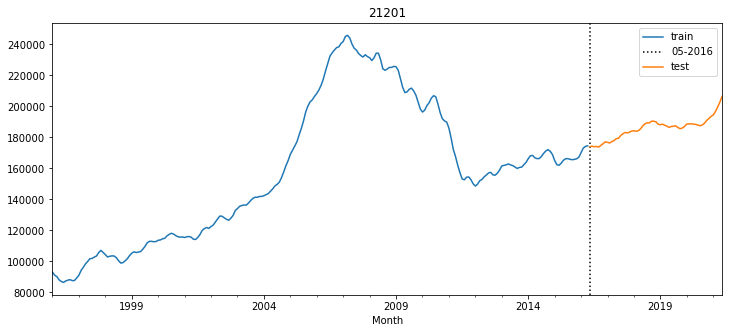

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              21201   No. Observations:                  244
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -2196.268
Date:                            Fri, 02 Jul 2021   AIC                           4402.536
Time:                                    13:00:34   BIC                           4420.001
Sample:                                01-31-1996   HQIC                          4409.570
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9503      0.069     13.826      0.000       0.816       1.085
ar.L2         -0.0375      0.016     -2.386      0.017      -0.068      -0.007
ma.L1         -0.8721      0.069    -12.684      0.000      -1.007      -0.737
ma.S.L12      -0.0284      0.018     -1.573      0.116      -0.064       0.007
sigma2      3.981e+06   6.68e-09   5.96e+14      0.000    3.98e+06    3.98e+06
===================================================================================
Ljung-Box (Q):                      353.57   Jarque-Bera (JB):                58.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.82   Skew:                            -0.93
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.32e+30. Standard errors may be unstable.
"""

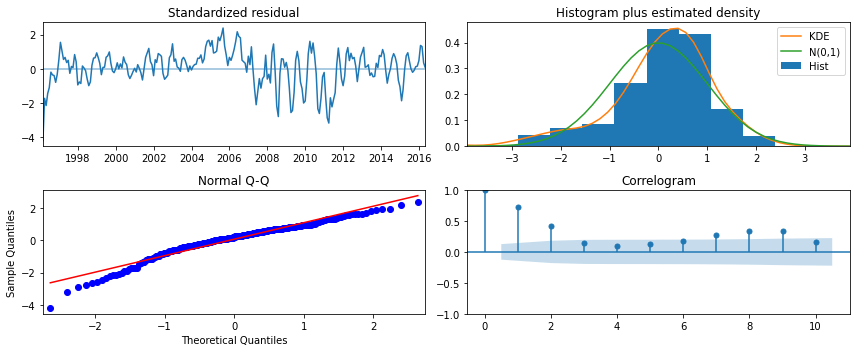

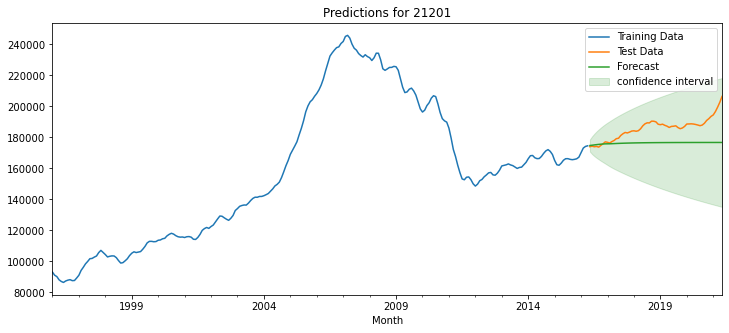

Metric,RMSE,R2,Thiel's U
Value,11391.101,-1.774,9.996


	- TRAINING FINAL MODEL:


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              21201   No. Observations:                  305
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -2727.648
Date:                            Fri, 02 Jul 2021   AIC                           5465.296
Time:                                    13:00:36   BIC                           5483.881
Sample:                                01-31-1996   HQIC                          5472.731
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1076      0.009    118.565      0.000       1.089       1.126
ar.L2         -0.1130      0.007    -15.238      0.000      -0.128      -0.099
ma.L1         -0.9868      0.006   -152.684      0.000      -0.999      -0.974
ma.S.L12      -0.0131      0.023     -0.559      0.576      -0.059       0.033
sigma2      3.391e+06    5.6e-10   6.06e+15      0.000    3.39e+06    3.39e+06
===================================================================================
Ljung-Box (Q):                      453.50   Jarque-Bera (JB):               333.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -1.34
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.41e+31. Standard errors may be unstable.
"""

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21201,207108.276,2023-05-31,2.101,-8.171,12.374


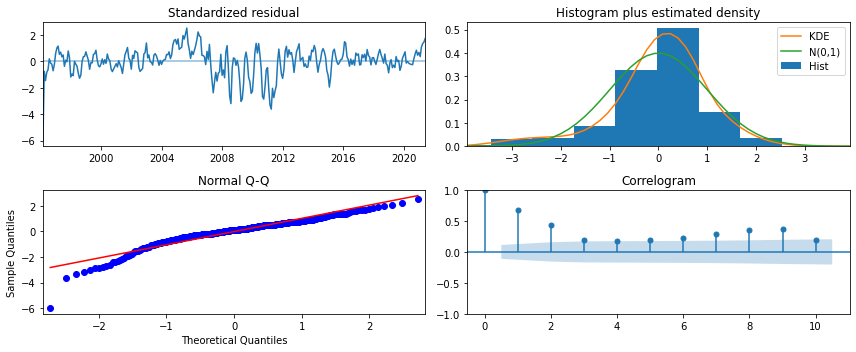

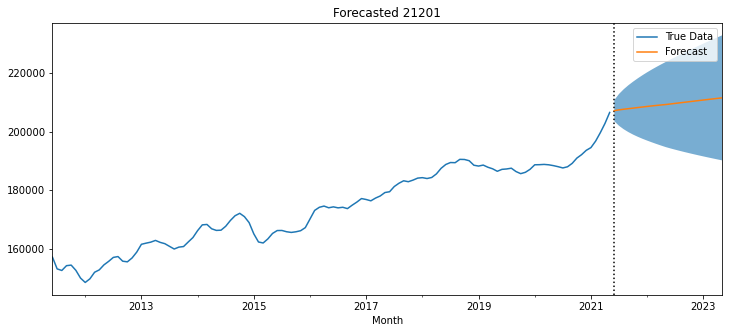

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21201,207108.276,2023-05-31,2.101,-8.171,12.374





[i] GRIDSEARCHING FOR 21201:


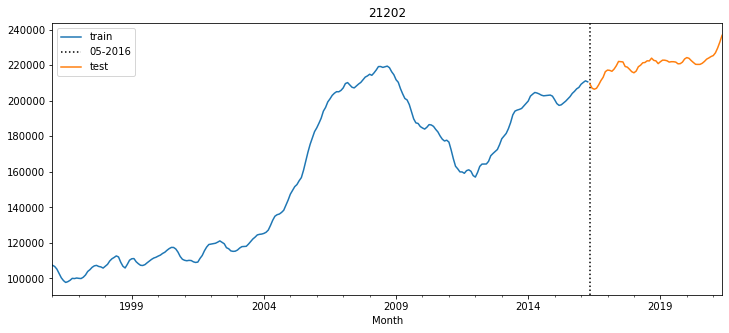

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  21202   No. Observations:                  244
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -2149.232
Date:                Fri, 02 Jul 2021   AIC                           4306.465
Time:                        13:00:56   BIC                           4320.437
Sample:                    01-31-1996   HQIC                          4312.093
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6766      0.025     26.582      0.000       0.627       0.726
ar.L2         -0.0094      0.008     -1.211      0.226      -0.025       0.006
ma.L1         -1.6474      0.070    -23.438      0.000      -1.785      -1.510
sigma2      9.693e+05   6.77e-08   1.43e+13      0.000    9.69e+05    9.69e+05
===================================================================================
Ljung-Box (Q):                      498.87   Jarque-Bera (JB):                30.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.57
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+29. Standard errors may be unstable.
"""

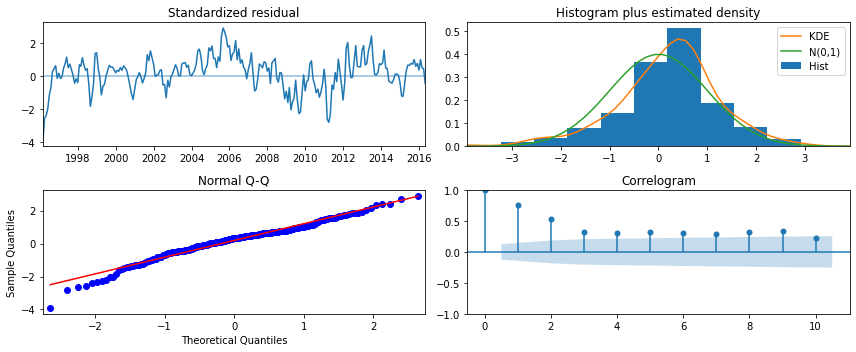

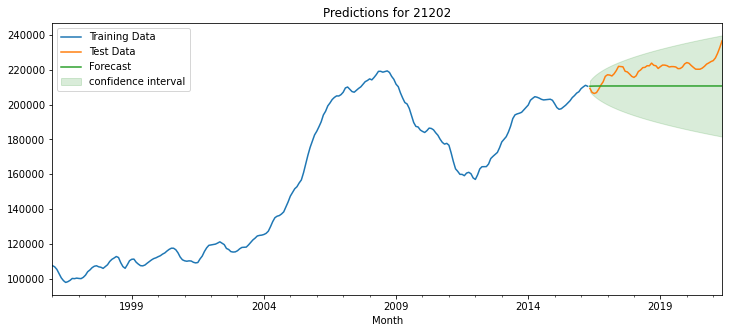

Metric,RMSE,R2,Thiel's U
Value,10967.275,-3.08,7.706


	- TRAINING FINAL MODEL:


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  21202   No. Observations:                  305
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -2676.493
Date:                Fri, 02 Jul 2021   AIC                           5360.987
Time:                        13:00:57   BIC                           5375.855
Sample:                    01-31-1996   HQIC                          5366.934
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7269      0.024     30.452      0.000       0.680       0.774
ar.L2         -0.0196      0.007     -2.733      0.006      -0.034      -0.006
ma.L1         -1.5481      0.059    -26.353      0.000      -1.663      -1.433
sigma2      1.006e+06   5.29e-08    1.9e+13      0.000    1.01e+06    1.01e+06
===================================================================================
Ljung-Box (Q):                      474.92   Jarque-Bera (JB):                59.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.60
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.81e+28. Standard errors may be unstable.
"""

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21202,237262.441,2023-05-31,0.412,-7.029,7.854


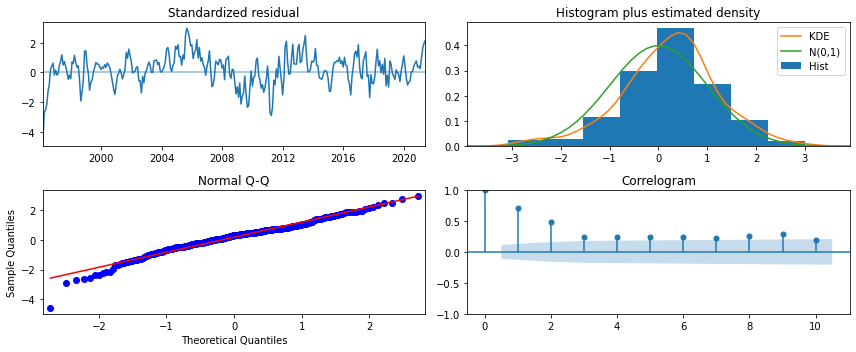

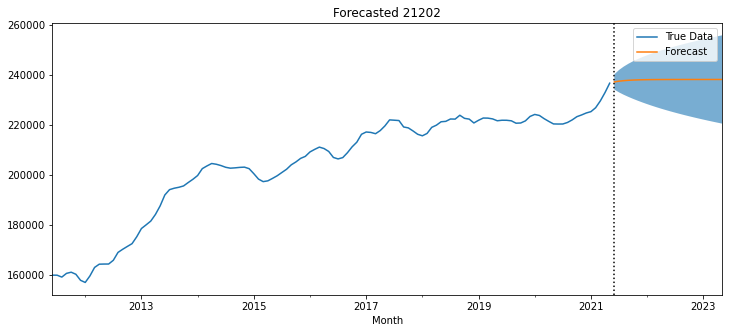

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21202,237262.441,2023-05-31,0.412,-7.029,7.854





[i] GRIDSEARCHING FOR 21202:


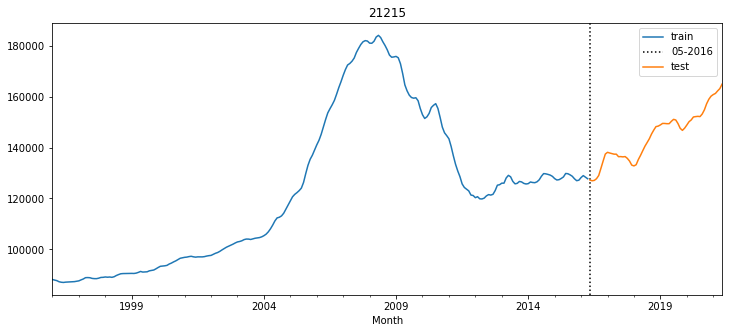

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting para

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py:437: ModelFitWarning:

Error fitting  ARIMA(3,1,4)(1,0,0)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py", line 421, in _fit_candidate_model
    fit.fit(x, exogenous=xreg, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/arima.py", line 472, in fit
    self._fit(y, exoge

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               21215   No. Observations:                  244
Model:             SARIMAX(2, 1, 3)x(1, 0, [], 12)   Log Likelihood               -2052.676
Date:                             Fri, 02 Jul 2021   AIC                           4119.352
Time:                                     13:03:49   BIC                           4143.803
Sample:                                 01-31-1996   HQIC                          4129.201
                                      - 04-30-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2568      0.126      9.989      0.000       1.010       1.503
ar.L2         -0.3408      0.089     -3.850      0.000      -0.514      -0.167
ma.L1         -2.5268      0.117    -21.687      0.000      -2.755      -2.298
ma.L2          1.1406      0.232      4.907      0.000       0.685       1.596
ma.L3          0.1459      0.056      2.600      0.009       0.036       0.256
ar.S.L12      -0.0417      0.016     -2.657      0.008      -0.072      -0.011
sigma2      3.188e+05   7.96e-07   4.01e+11      0.000    3.19e+05    3.19e+05
===================================================================================
Ljung-Box (Q):                      623.77   Jarque-Bera (JB):                72.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+27. Standard errors may be unstable.
"""

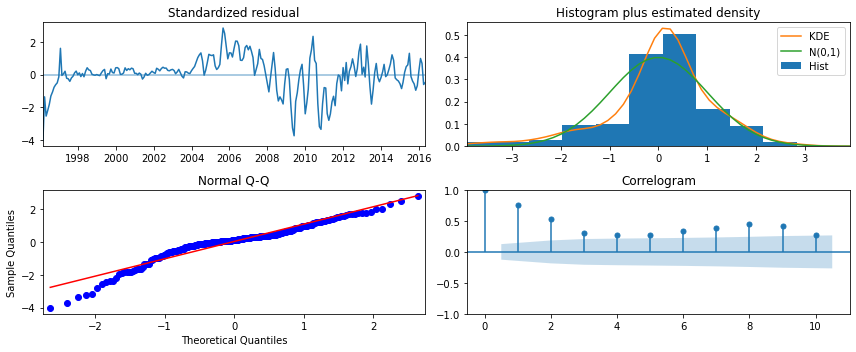

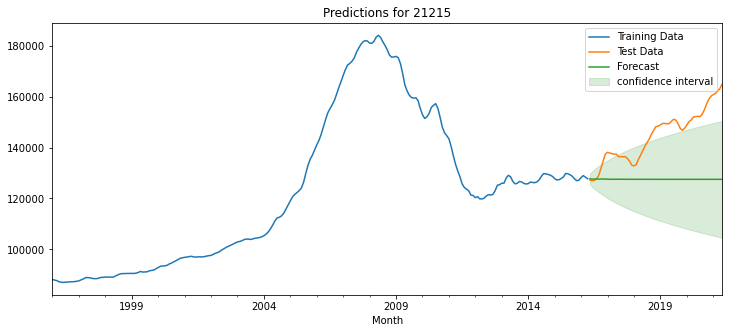

Metric,RMSE,R2,Thiel's U
Value,19710.468,-2.913,15.011


	- TRAINING FINAL MODEL:


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               21215   No. Observations:                  305
Model:             SARIMAX(2, 1, 3)x(1, 0, [], 12)   Log Likelihood               -2573.009
Date:                             Fri, 02 Jul 2021   AIC                           5160.019
Time:                                     13:03:51   BIC                           5186.038
Sample:                                 01-31-1996   HQIC                          5170.427
                                      - 05-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0898   1562.977   5.74e-05      1.000   -3063.289    3063.469
ar.L2          0.3893   1047.912      0.000      1.000   -2053.480    2054.259
ma.L1         -1.2606   1562.976     -0.001      0.999   -3064.637    3062.116
ma.L2         -1.0406   2877.819     -0.000      1.000   -5641.463    5639.382
ma.L3          0.0166     44.582      0.000      1.000     -87.363      87.396
ar.S.L12      -0.0116      0.032     -0.361      0.718      -0.074       0.051
sigma2      3.296e+05     50.948   6470.289      0.000     3.3e+05     3.3e+05
===================================================================================
Ljung-Box (Q):                      645.94   Jarque-Bera (JB):               235.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -1.10
Prob(H) (two-sided):                  0.09   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.08e+19. Standard errors may be unstable.
"""

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21215,165217.671,2023-05-31,0.329,-7.595,8.253


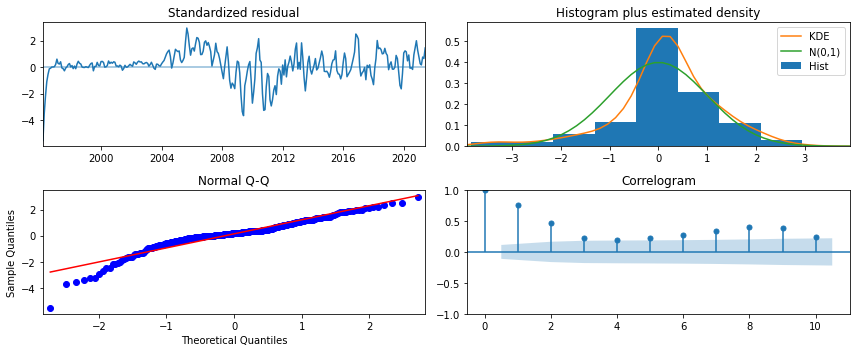

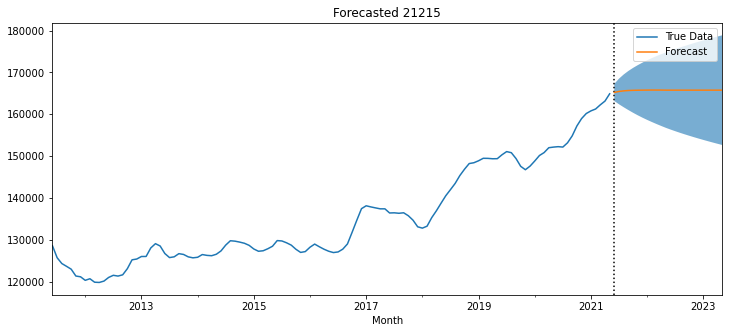

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21215,165217.671,2023-05-31,0.329,-7.595,8.253





[i] GRIDSEARCHING FOR 21215:


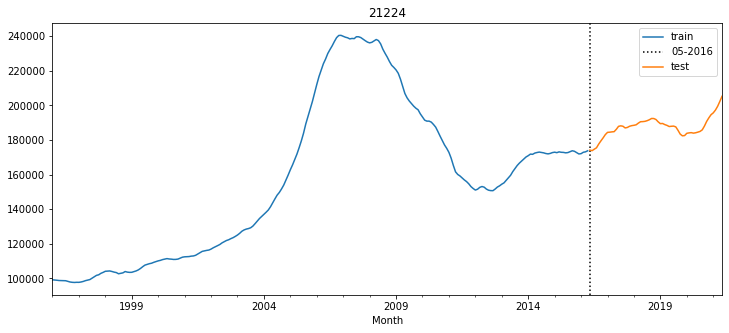

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py:437: ModelFitWarning:

Error fitting  ARIMA(1,1,0)(2,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py", line 421, in _fit_candidate_model
    fit.fit(x, exogenous=xreg, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/arima.py", line 472, in fit
    self._fit(y, exogenous, **fit_args)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pmdarima/arima/arima.py", line 397, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/anaconda3/envs/learn-env/l

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  21224   No. Observations:                  244
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2089.648
Date:                Fri, 02 Jul 2021   AIC                           4189.295
Time:                        13:05:35   BIC                           4206.760
Sample:                    01-31-1996   HQIC                          4196.330
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3403      0.042     31.647      0.000       1.257       1.423
ar.L2         -0.3875      0.028    -13.658      0.000      -0.443      -0.332
ma.L1         -3.2081      0.091    -35.307      0.000      -3.386      -3.030
ma.L2          2.0128      0.099     20.413      0.000       1.820       2.206
sigma2      2.562e+05   7.82e-07   3.28e+11      0.000    2.56e+05    2.56e+05
===================================================================================
Ljung-Box (Q):                     1174.51   Jarque-Bera (JB):                27.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.38
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.38e+26. Standard errors may be unstable.
"""

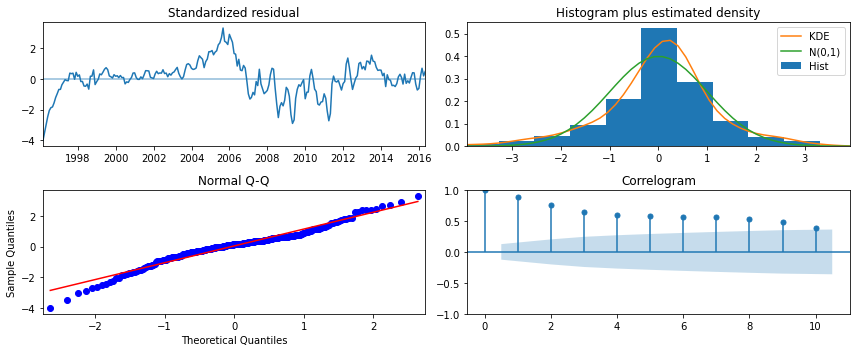

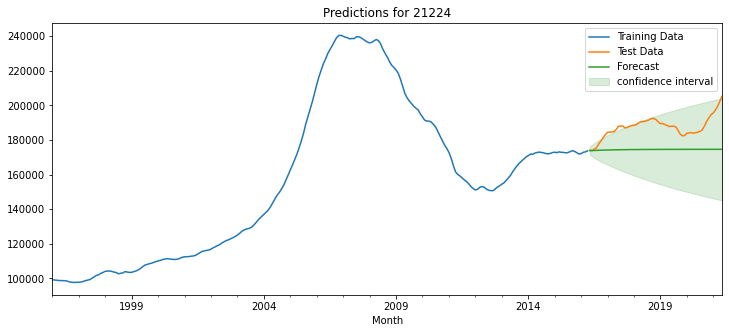

Metric,RMSE,R2,Thiel's U
Value,14184.415,-4.673,11.589


	- TRAINING FINAL MODEL:


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  21224   No. Observations:                  305
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2603.992
Date:                Fri, 02 Jul 2021   AIC                           5217.985
Time:                        13:05:37   BIC                           5236.570
Sample:                    01-31-1996   HQIC                          5225.419
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9234      0.014    140.374      0.000       1.897       1.950
ar.L2         -0.9253      0.013    -72.297      0.000      -0.950      -0.900
ma.L1         -1.8496      0.016   -115.843      0.000      -1.881      -1.818
ma.L2          0.8526      0.015     57.956      0.000       0.824       0.881
sigma2      9.888e+05   1.68e-09   5.89e+14      0.000    9.89e+05    9.89e+05
===================================================================================
Ljung-Box (Q):                      943.56   Jarque-Bera (JB):               110.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.71
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.89e+30. Standard errors may be unstable.
"""

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21224,206167.371,2023-05-31,4.22,-3.045,11.484


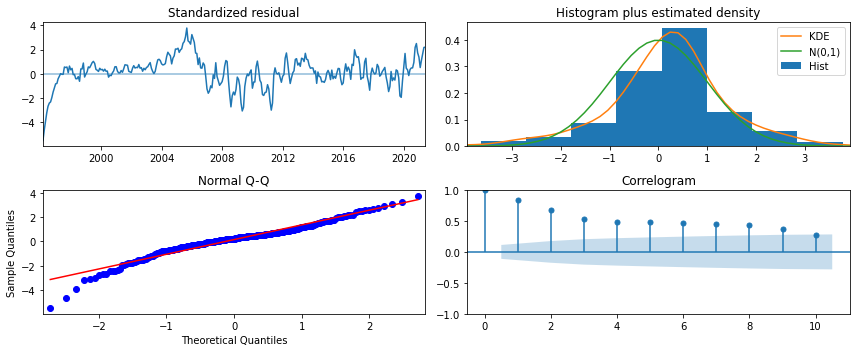

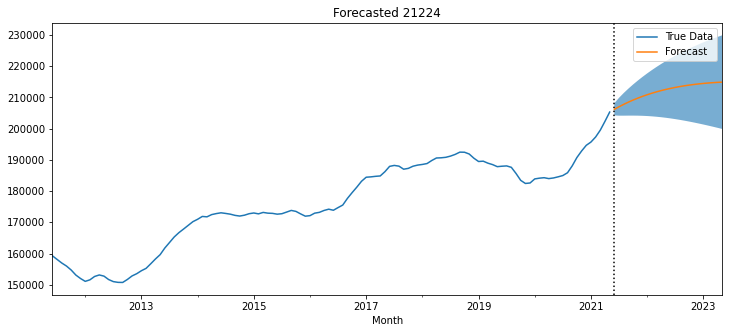

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21224,206167.371,2023-05-31,4.22,-3.045,11.484





[i] GRIDSEARCHING FOR 21224:


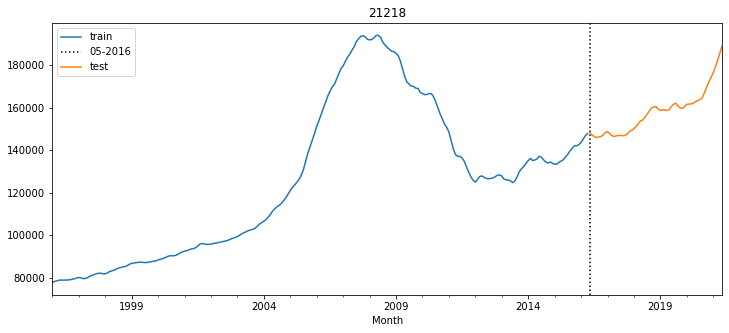

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                21218   No. Observations:                  244
Model:             SARIMAX(3, 1, 3)x(0, 0, [1], 12)   Log Likelihood               -2098.252
Date:                              Fri, 02 Jul 2021   AIC                           4212.504
Time:                                      13:09:04   BIC                           4240.449
Sample:                                  01-31-1996   HQIC                          4223.760
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2763      0.204      1.352      0.176      -0.124       0.677
ar.L2          0.7340      0.264      2.782      0.005       0.217       1.251
ar.L3         -0.1028      0.099     -1.040      0.298      -0.297       0.091
ma.L1          0.0228      0.204      0.112      0.911      -0.376       0.422
ma.L2         -0.6519      0.208     -3.131      0.002      -1.060      -0.244
ma.L3         -0.0651      0.060     -1.076      0.282      -0.184       0.053
ma.S.L12      -0.1213      0.015     -7.866      0.000      -0.152      -0.091
sigma2      2.706e+05      1e+04     26.974      0.000    2.51e+05     2.9e+05
===================================================================================
Ljung-Box (Q):                      338.19   Jarque-Bera (JB):               832.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -1.61
Prob(H) (two-sided):                  0.21   Kurtosis:                        11.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

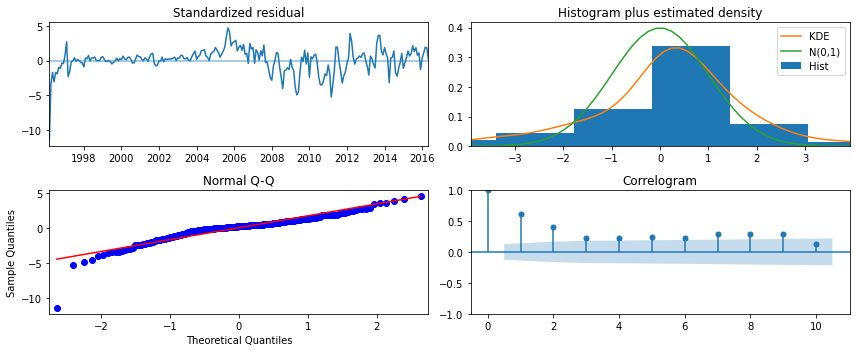

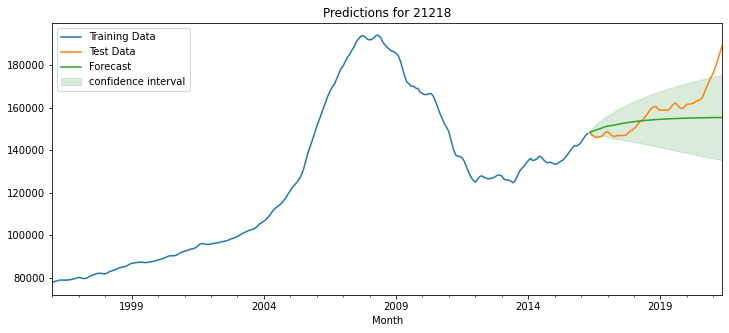

Metric,RMSE,R2,Thiel's U
Value,9992.361,0.068,7.516


	- TRAINING FINAL MODEL:


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                21218   No. Observations:                  305
Model:             SARIMAX(3, 1, 3)x(0, 0, [1], 12)   Log Likelihood               -2606.045
Date:                              Fri, 02 Jul 2021   AIC                           5228.090
Time:                                      13:09:07   BIC                           5257.827
Sample:                                  01-31-1996   HQIC                          5239.986
                                       - 05-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4638      0.169      2.736      0.006       0.132       0.796
ar.L2          0.4039      0.246      1.641      0.101      -0.078       0.886
ar.L3          0.0407      0.097      0.420      0.674      -0.149       0.231
ma.L1         -0.1433      0.169     -0.847      0.397      -0.475       0.188
ma.L2         -0.3665      0.197     -1.857      0.063      -0.753       0.020
ma.L3         -0.1753      0.055     -3.160      0.002      -0.284      -0.067
ma.S.L12      -0.1418      0.011    -12.842      0.000      -0.163      -0.120
sigma2      2.886e+05   1.09e+04     26.360      0.000    2.67e+05     3.1e+05
===================================================================================
Ljung-Box (Q):                      322.12   Jarque-Bera (JB):              1794.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -1.81
Prob(H) (two-sided):                  0.87   Kurtosis:                        14.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21218,190772.459,2023-05-31,6.953,1.132,12.774


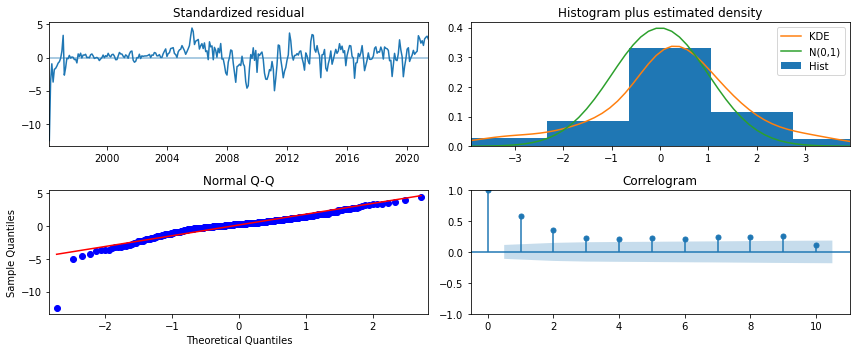

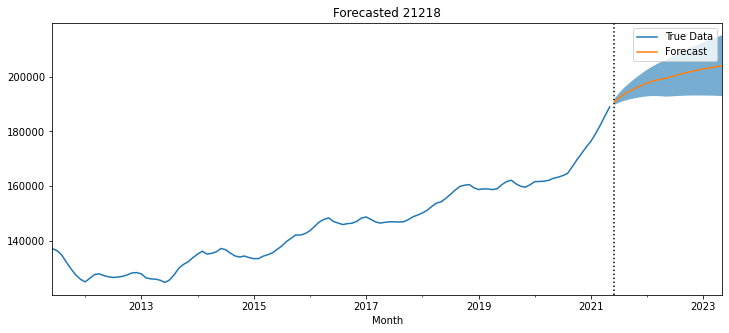

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21218,190772.459,2023-05-31,6.953,1.132,12.774


In [33]:
RESULTS = {}
for zipcode in ['21201','21202','21215', '21224', '21218',]: ## pulling out individual zipcode
    
    ## Make emoty dict for zipcode's results
    zipcode_results = {}
    
    print('==='*20)
    print(f'[i] GRIDSEARCHING FOR {ts.name}:') 
    ts = BCTY[zipcode].copy()
    train,test = train_test_split_ts(ts)
    plt.show()
    
    
    #### GRISEARCHING BEST PARAMS

    auto_model = pmd.auto_arima(train,start_p=0,max_p=5,
                               start_q=0,max_q=5,d=1,m=12,
                               start_P=0,start_Q=0,maxiter=150,
                                verbose=True,trace=False)

    ## Fit SARIMAX with best parmas and compare forecast vs test
    best_model = tsa.SARIMAX(train,order=auto_model.order,
                            seasonal_order = auto_model.seasonal_order,
                            enforce_invertibility=False,
                             enforce_stationarity=True).fit()
    ## Display Summary + Diagnostics
    display(best_model.summary())
    best_model.plot_diagnostics();
    plt.tight_layout();
    
    ## Get tts forecast comparison
    res,tts_fig,ax = plot_forecast_vs_test(best_model,train,test)

    

    print('\t- TRAINING FINAL MODEL:')
    
    ## If happy with the model's test perforamance, retrain on entire ts and forecast into future
    ## Fit a final model and evaluate
    final_model = tsa.SARIMAX(ts,order=auto_model.order,
                    seasonal_order = auto_model.seasonal_order,
                    enforce_invertibility=False).fit()


    ## Display Summary + Diagnostics
    display(final_model.summary())
    final_model.plot_diagnostics();
    plt.tight_layout()
    
    ## save final model
    
    forecast_fig, roi_df = plot_future_forecast(final_model,ts,
                                               last_n_lags=12*10,
                                               future_steps=24);
    plt.show()
    display(roi_df)
    ## Fill in  results and
    zipcode_results['tts_fig']= tts_fig
    zipcode_results['final_model'] = final_model
    zipcode_results['forecast'] = forecast_fig
    zipcode_results['roi'] = roi_df
    
#     del forecst_fig, tts_fig,roi_df
    
    ## Saving zipcode results to RESULTS dict
    RESULTS[zipcode] = zipcode_results
    print("\n\n")

In [34]:
RESULTS.keys()

dict_keys(['21201', '21202', '21215', '21224', '21218'])

In [35]:
RESULTS['21201'].keys()

dict_keys(['tts_fig', 'final_model', 'forecast', 'roi'])

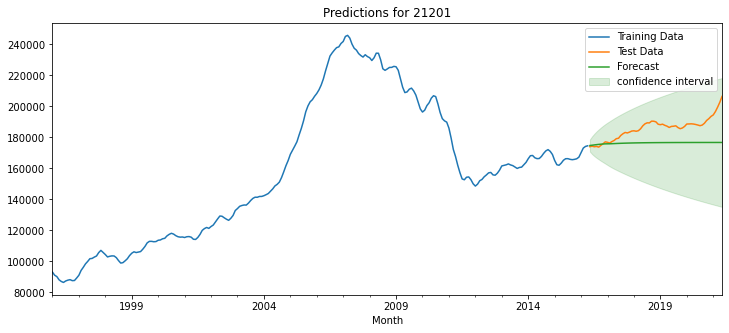

In [36]:
RESULTS['21201']['tts_fig']

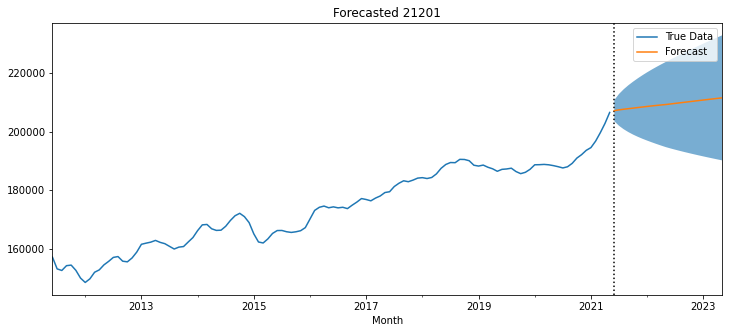

,Investment Cost,Sale Date,Forecast,Lower CI,Upper CI
21201,207108.276,2023-05-31,2.101,-8.171,12.374


In [37]:
display(RESULTS['21201']['forecast'])
RESULTS['21201']['roi']

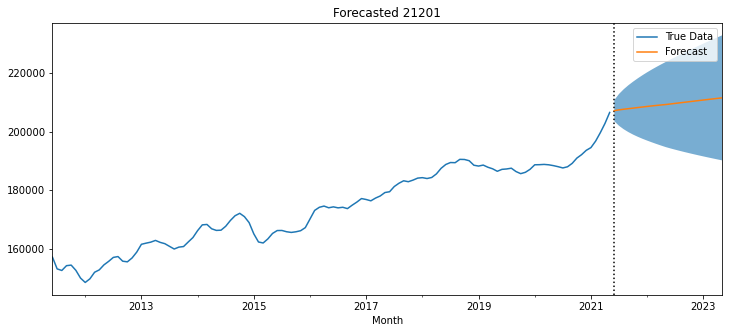

In [38]:
display(RESULTS['21201']['forecast'])
print()

In [39]:
## concatenating roi dfs for each zipcode into 1 df
roi_dfs = []
for zipname, zipdict in RESULTS.items():
    roi_dfs.append(zipdict['roi'])
    
overall_rois = pd.concat(roi_dfs)
overall_rois.sort_values('Forecast',ascending=False, inplace=True)
overall_rois.drop(columns='Sale Date',inplace=True)
overall_rois.style.background_gradient(subset=['Investment Cost','Forecast'],
                                       cmap='Greens').set_caption('Top Zipcodes by ROI')

,Investment Cost,Forecast,Lower CI,Upper CI
21218,190772.459,6.953,1.132,12.774
21224,206167.371,4.220,-3.045,11.484
21201,207108.276,2.101,-8.171,12.374
21202,237262.441,0.412,-7.029,7.854
21215,165217.671,0.329,-7.595,8.253


In [40]:
## looping through dict to save the forecast figures
import os
fig_folder = "./images/"
os.makedirs(fig_folder,exist_ok=True)

for zipcode in RESULTS:
    fig = RESULTS[zipcode]['forecast']
    fig.savefig(f"{fig_folder}forecast_for_{zipcode}.png",dpi=300)